## Classification of Horses vs Humans

Data downloaded from https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip containing around 1280 CGI generated images of horses and humans in different poses.  

In [1]:
#Importing the necessary libraries
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [6]:
#Loading the pretrained inception model

INCEPTION_WEIGHTS = r"C:\Users\ku.kulshrestha\Downloads\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

#Instance of the inception model from the local pre-trained weights
local_weights_file = INCEPTION_WEIGHTS

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                               weights=None,
                               include_top=False)

pre_trained_model.load_weights(local_weights_file)

# Making all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable=False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 74, 74, 32)   96          conv2d_79[0][0]                  
__________________________________________________________________________________________________
activation_78 (Activation)      (None, 74, 74, 32)   0           batch_normalization_78[0][0]     
_______________________________________________________________________________________

In [7]:
#Using the outpt of mixed7 layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [8]:
#Callback definition for stoping training at 97% accuracy 

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True


In [9]:
# Addition of final trainable layers

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 74, 74, 32)   96          conv2d_79[0][0]                  
__________________________________________________________________________________________________
activation_78 (Activation)      (None, 74, 74, 32)   0           batch_normalization_78[0][0]     
______________________________________________________________________________________________

In [12]:
#Unziping the data

path_horse_or_human = r"C:\Users\ku.kulshrestha\Documents\CourseraTensorflow\C2CNN\horse-or-human.zip"
path_validation_horse_or_human = r"C:\Users\ku.kulshrestha\Documents\CourseraTensorflow\C2CNN\validation-horse-or-human.zip"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import shutil

local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(r'C:\Users\ku.kulshrestha\Documents\github repos\mini-projects\data\horse-or-human-training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(r'C:\Users\ku.kulshrestha\Documents\github repos\mini-projects\data\horse-or-human-validation')
zip_ref.close()

In [13]:
# Define our example directories and files
train_dir = r'C:\Users\ku.kulshrestha\Documents\github repos\mini-projects\data\horse-or-human-training'
validation_dir = r'C:\Users\ku.kulshrestha\Documents\github repos\mini-projects\data\horse-or-human-validation'

train_horses_dir = os.path.join(train_dir,'horses')
train_humans_dir = os.path.join(train_dir,'humans')
validation_horses_dir = os.path.join(validation_dir,'horses')
validation_humans_dir = os.path.join(validation_dir,'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))


500
527
128
128


In [14]:
#Setting up training and validation ImageDataGenerators

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  shear_range=0.2,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  rotation_range=40,
                                  zoom_range=0.2,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   target_size=(150,150))     

validation_generator =  test_datagen.flow_from_directory(directory=validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150,150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [16]:
#Training the model

callbacks = myCallback()
history = model.fit_generator(train_generator, 
                             epochs=10,
                             validation_data=validation_generator,
                              steps_per_epoch=50,
                              validation_steps=50,
                              verbose=1,
                             callbacks=[callbacks])

Epoch 1/10
50/50 [==============================] - 355s 7s/step - loss: 0.1932 - accuracy: 0.9240 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/10
50/50 [==============================] - 378s 8s/step - loss: 0.1337 - accuracy: 0.9497 - val_loss: 2.9063e-04 - val_accuracy: 1.0000
Epoch 3/10
49/50 [============================>.] - ETA: 6s - loss: 0.0714 - accuracy: 0.9721 
Reached 97.0% accuracy so cancelling training!
50/50 [==============================] - 375s 7s/step - loss: 0.0710 - accuracy: 0.9716 - val_loss: 2.6571e-04 - val_accuracy: 1.0000


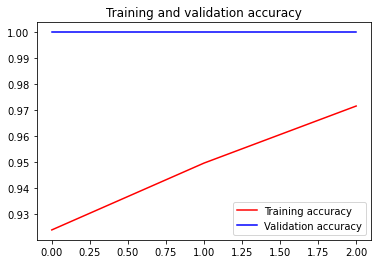

<Figure size 432x288 with 0 Axes>

In [17]:
#Plotting training and validation loss and accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()